In [2]:
import pandas as pd
import numpy as np 
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
spotify_songs = pd.read_csv ('/content/drive/MyDrive/DATA ENGINEERING/Music Data/1_spotify_songs.csv')
billboard = pd.read_csv ('/content/drive/MyDrive/DATA ENGINEERING/Music Data/2_billboard.csv')
artist_a = pd.read_csv ('/content/drive/MyDrive/DATA ENGINEERING/Music Data/3_artists.csv')
tracks_a = pd.read_csv ('/content/drive/MyDrive/DATA ENGINEERING/Music Data/3_tracks.csv')
albums_b = pd.read_csv ('/content/drive/MyDrive/DATA ENGINEERING/Music Data/4_albums.csv')
artists_b = pd.read_csv ('/content/drive/MyDrive/DATA ENGINEERING/Music Data/4_artists.csv')

In [5]:
#tracks_a = tracks_a[["id","name","artists","id_artists"]]
songs = spotify_songs
artist = pd.merge(artist_a, artists_b, how = "left", left_on=['name'], right_on = ['art_name']) # use artist ID to match with song 
album = albums_b # use album name to match with songs
chart = billboard #use song name to match

In [6]:
artist = artist[["id_x","name","followers","popularity"]]
songs = songs.drop(["track_album_id","track_album_release_date","playlist_name","playlist_id","playlist_genre","playlist_subgenre"],axis = 1)
album = album.drop(["id","artist_id","genre","year_of_pub","num_of_tracks"],axis =1)
chart_h = chart[["song","peak-rank"]]
chart_peak = chart_h.groupby("song").min("peak-rank").reset_index()


In [7]:
data = pd.merge(songs,artist,how = "inner", left_on=["track_artist"],right_on=["name"])
data = data.drop(["id_x","name","mode"],axis=1)
data = pd.merge(data,album,how = "left", left_on=["track_album_name"],right_on=["album_title"])
data = data.drop(["album_title"],axis=1)
#data = pd.merge(data,chart_peak,how = "left", left_on=["track_name"], right_on=["song"])
data = pd.merge(data,chart_peak,how = "inner", left_on=["track_name"], right_on=["song"])
data = data.drop(["song"],axis=1)
data

,track_id,track_name,track_artist,track_popularity,track_album_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,followers,popularity,num_of_sales,rolling_stone_critic,mtv_critic,music_maniac_critic,peak-rank
0,1HNkqx9Ahdgi1Ixy2xkKkL,Photograph,Ed Sheeran,84,x (Deluxe Edition),0.614,0.379,4,-10.480,0.0476,0.607000,0.000464,0.0986,0.201,107.989,258987,78900234.0,92,NaN,NaN,NaN,NaN,1
1,3FSPaBp49Clqq2p4zc9dbA,Photograph,Ed Sheeran,52,x (Wembley Edition),0.614,0.379,4,-10.480,0.0476,0.607000,0.000464,0.0986,0.201,107.989,258987,78900234.0,92,NaN,NaN,NaN,NaN,1
2,1HNkqx9Ahdgi1Ixy2xkKkL,Photograph,Ed Sheeran,84,x (Deluxe Edition),0.614,0.379,4,-10.480,0.0476,0.607000,0.000464,0.0986,0.201,107.989,258987,78900234.0,92,NaN,NaN,NaN,NaN,1
3,1HNkqx9Ahdgi1Ixy2xkKkL,Photograph,Ed Sheeran,84,x (Deluxe Edition),0.614,0.379,4,-10.480,0.0476,0.607000,0.000464,0.0986,0.201,107.989,258987,78900234.0,92,NaN,NaN,NaN,NaN,1
4,18URo35acNKRTHfEdjTcGn,Photograph,Def Leppard,64,Pyromania,0.602,0.877,4,-6.606,0.0515,0.000343,0.635000,0.0551,0.617,123.679,247962,3150061.0,73,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17394,6Vn1LjyhzU7mXOtTYzBKkQ,All To Myself,Nolan van Lith,6,All To Myself,0.455,0.562,2,-5.031,0.0293,0.005040,0.000000,0.3650,0.282,128.042,220000,4435.0,35,NaN,NaN,NaN,NaN,31
17395,7uIKTNMTtL1Ssmt4NpJTjk,I Was Born To Love You,Timeless Legend,32,Synchronized,0.659,0.811,2,-9.758,0.0813,0.015800,0.003900,0.0399,0.884,117.604,223187,490.0,19,NaN,NaN,NaN,NaN,76
17396,38hXTl0Gf7pXePh6yzl0hB,Yours,Oh Snap It's Luke!,26,Yours,0.550,0.879,7,-4.213,0.0411,0.004840,0.000180,0.4320,0.224,122.037,210492,2028.0,21,NaN,NaN,NaN,NaN,49
17397,3CoDXg77Rae8RnbAwdoZGj,Dance With You,Lemonface,23,Dance With You,0.857,0.410,9,-7.912,0.0543,0.018400,0.000078,0.0769,0.814,114.986,187826,87.0,9,NaN,NaN,NaN,NaN,70


In [8]:
#data["peak-rank"].fillna(0,inplace = True)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data[["num_of_sales","rolling_stone_critic","mtv_critic","music_maniac_critic"]]=imp_mean.fit_transform(data[["num_of_sales","rolling_stone_critic","mtv_critic","music_maniac_critic"]])
data.isnull().sum()

track_id                0
track_name              0
track_artist            0
track_popularity        0
track_album_name        0
danceability            0
energy                  0
key                     0
loudness                0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
duration_ms             0
followers               0
popularity              0
num_of_sales            0
rolling_stone_critic    0
mtv_critic              0
music_maniac_critic     0
peak-rank               0
dtype: int64

In [11]:
popularity = data["track_popularity"]
features = data.iloc[:,5:22]
peak_rank = data["peak-rank"]
features.dtypes

danceability            float64
energy                  float64
key                       int64
loudness                float64
speechiness             float64
acousticness            float64
instrumentalness        float64
liveness                float64
valence                 float64
tempo                   float64
duration_ms               int64
followers               float64
popularity                int64
num_of_sales            float64
rolling_stone_critic    float64
mtv_critic              float64
music_maniac_critic     float64
dtype: object

In [29]:
#popularity
#linear Regression
X_train, X_test, y_train, y_test = train_test_split(features, popularity, test_size=0.2)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred= lr.predict(X_test)
# RMSE
print("RMSE = {}".format(np.sqrt(np.mean((y_pred - y_test)**2))))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


RMSE = 24.83263258970522
Mean squared error: 616.66
Coefficient of determination: 0.19


In [19]:
parameters_refine = {
    'max_depth': [30,None,50,100], 
    'min_samples_split':[5,10,50,100],
    'min_samples_leaf':[5,10,50],
}
gscv_r = GridSearchCV(DecisionTreeRegressor(), parameters_refine, cv=5)
gscv_r.fit(X_train, y_train)
gscv_r.best_params_

{'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 50}

In [23]:
#decision Tree
clf = DecisionTreeRegressor(max_depth=50, min_samples_leaf=10, min_samples_split=50)
#clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("RMSE = {}".format(np.sqrt(np.mean((y_pred - y_test)**2))))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

RMSE = 18.957208522594808
Mean squared error: 359.38
Coefficient of determination: 0.54


In [32]:
parameters_refine = {
    'max_depth': [5,10,30,None], 
    'min_samples_split':[5,10,20],
    'min_samples_leaf':[2,4,10]
}
gscv_r = GridSearchCV(RandomForestRegressor(), parameters_refine, cv=5)
gscv_r.fit(X_train, y_train)
gscv_r.best_params_

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}

In [35]:
param_grid = {'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
gscv_r = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
gscv_r.fit(X_train, y_train)
gscv_r.best_params_

{'max_features': 'log2', 'n_estimators': 100}

In [40]:
rf = RandomForestRegressor()
#rf = RandomForestRegressor(max_depth=None, min_samples_leaf=2, \
                           #min_samples_split=5, max_features = 'log2', n_estimators = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RMSE = {}".format(np.sqrt(np.mean((y_pred - y_test)**2))))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

RMSE = 15.628606470828544
Mean squared error: 244.25
Coefficient of determination: 0.68


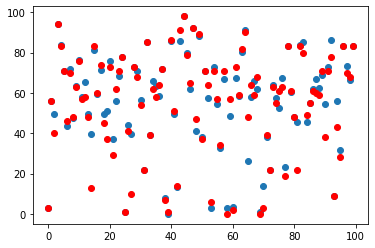

In [ ]:
x = list(range(0,100))
plt.scatter(x,y_pred[0:100])
plt.scatter(x,y_test[0:100],color="red")

In [ ]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(features, peak_rank, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train_b, y_train_b)
y_pred_b= lr.predict(X_test_b)
# RMSE
print("RMSE = {}".format(np.sqrt(np.mean((y_pred_b - y_test_b)**2))))
print("Mean squared error: %.2f" % mean_squared_error(y_test_b, y_pred_b))
print("Coefficient of determination: %.2f" % r2_score(y_test_b, y_pred_b))

RMSE = 27.023761118986553
Mean squared error: 730.28
Coefficient of determination: 0.04


In [ ]:
parameters_refine = {
    'max_depth': [30,None,50,100], 
    'min_samples_split':[5,10,50,100],
    'min_samples_leaf':[5,10,50],
}
gscv_r = GridSearchCV(DecisionTreeRegressor(), parameters_refine, cv=5)
gscv_r.fit(X_train_b, y_train_b)
gscv_r.best_params_

{'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 10}

In [ ]:
#decision Tree
clf = DecisionTreeRegressor(max_depth=50, min_samples_leaf=10, min_samples_split=10)
clf = DecisionTreeRegressor()
clf.fit(X_train_b, y_train_b)
y_pred_b = clf.predict(X_test_b)
print("RMSE = {}".format(np.sqrt(np.mean((y_pred_b - y_test_b)**2))))
print("Mean squared error: %.2f" % mean_squared_error(y_test_b, y_pred_b))
print("Coefficient of determination: %.2f" % r2_score(y_test_b, y_pred_b))

RMSE = 21.47946091919698
Mean squared error: 461.37
Coefficient of determination: 0.38


In [ ]:
param_grid = {'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
gscv_r = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
gscv_r.fit(X_train_b, y_train_b)
gscv_r.best_params_

{'max_features': 'log2', 'n_estimators': 80}

In [ ]:
#rf = RandomForestRegressor()
rf = RandomForestRegressor(max_depth=None, min_samples_leaf=1, \
                           min_samples_split=2, max_features = 'log2', n_estimators = 80)
rf.fit(X_train_b, y_train_b)
y_pred_b = rf.predict(X_test_b)
print("RMSE = {}".format(np.sqrt(np.mean((y_pred_b - y_test_b)**2))))
print("Mean squared error: %.2f" % mean_squared_error(y_test_b, y_pred_b))
print("Coefficient of determination: %.2f" % r2_score(y_test_b, y_pred_b))

RMSE = 15.728149436163884
Mean squared error: 247.37
Coefficient of determination: 0.67


In [ ]:
songs[songs["track_popularity"] == 100]

,track_id,track_name,track_artist,track_popularity,track_album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
1551,2XU0oxnq2qxCpomAAuJY8K,Dance Monkey,Tones and I,100,Dance Monkey (Stripped Back) / Dance Monkey,0.824,0.588,6,-6.4,0,0.0924,0.692,0.000104,0.149,0.513,98.027,209438
20091,2XU0oxnq2qxCpomAAuJY8K,Dance Monkey,Tones and I,100,Dance Monkey (Stripped Back) / Dance Monkey,0.824,0.588,6,-6.4,0,0.0924,0.692,0.000104,0.149,0.513,98.027,209438
